In [1]:
from functools import partial
from pathlib import Path
from typing import Any

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.custom_types import FloatScalar
from dynamics_discovery.dataset import TimeSeriesDataset
from dynamics_discovery.loss_functions import AbstractDynamicsLoss
from dynamics_discovery.models.abstract import AbstractDynamicsModel
from dynamics_discovery.models.neighborhood import (
    create_neighborhood_dataset,
)
from dynamics_discovery.preprocessing import (
    add_noise,
    standardize,
)
from jaxtyping import Array, Float, PyTree
from ott.utils import batched_vmap


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [32]:
dataset_loaded = TimeSeriesDataset.load(datadir / "lorenz63.hdf5")
noise = 0.05
n_steps = 10

t_train = dataset_loaded.t[0]
u_orig = dataset_loaded.u[0]
u_orig = add_noise(u_orig, noise)
u_train, transform = standardize(u_orig)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

In [33]:
t, u, du, _ = create_neighborhood_dataset(
    t_train,
    u_train,
    num_neighbors=30,
    train_length=n_steps,
    train_length_neighbors=n_steps,
    min_radius=0.0,
    max_radius=0.4,
)

In [34]:
du.shape

(9991, 10, 30, 3)

In [35]:
u.shape

(9991, 10, 3)

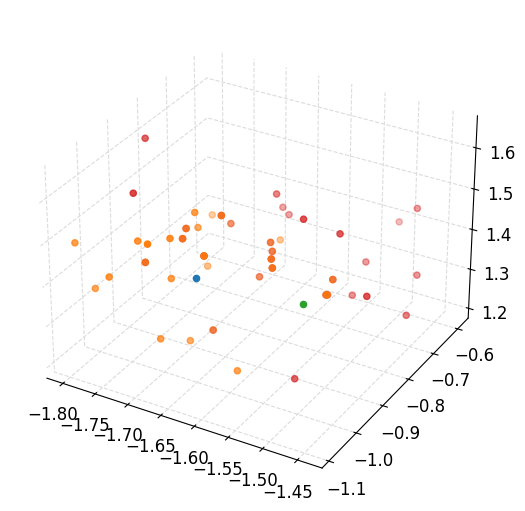

In [36]:
t_ind = 50

u_center = u[t_ind]
u_neigh = jnp.expand_dims(u_center, axis=-2) + du[t_ind]
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
ax.scatter(*u_center[0])
ax.scatter(*u_neigh[0].T)

ax.scatter(*u_center[1])
ax.scatter(*u_neigh[1].T)

In [37]:
def get_normal_direction(points: Float[Array, "batch dim"]):
    points_centered = points - jnp.mean(points, axis=0)
    _, _, Q_T = jnp.linalg.svd(points_centered)
    return Q_T[2]

In [38]:
u_samples = jnp.concatenate((jnp.expand_dims(u_center, axis=-2), u_neigh), axis=-2)
u_samples.shape

(10, 31, 3)

In [39]:
normals = jax.vmap(get_normal_direction)(u_samples)
normals.shape

(10, 3)

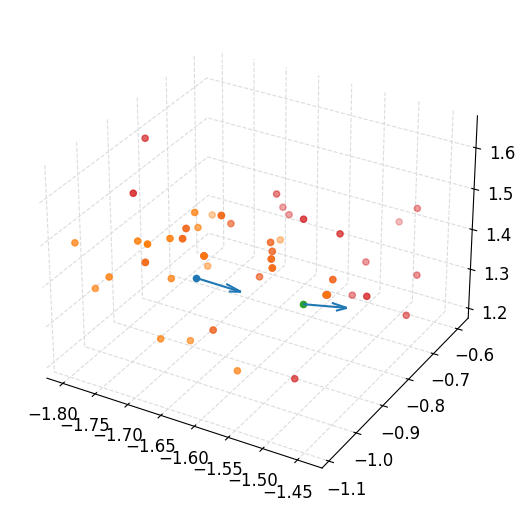

In [40]:
t_ind = 50

u_center = u[t_ind]
u_neigh = jnp.expand_dims(u_center, axis=-2) + du[t_ind]
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
ax.scatter(*u_center[0])
ax.scatter(*u_neigh[0].T)

ax.scatter(*u_center[1])
ax.scatter(*u_neigh[1].T)

ax.quiver(*u_center[0], *normals[0], length=0.1)
ax.quiver(*u_center[1], *normals[1], length=0.1)

In [41]:
u_neigh = jnp.expand_dims(u, axis=-2) + du
u_samples_batch = jnp.concatenate((jnp.expand_dims(u, axis=-2), u_neigh), axis=-2)
u_samples_batch.shape

(9991, 10, 31, 3)

In [42]:
normals_batch = jax.vmap(jax.vmap(get_normal_direction))(u_samples_batch)

In [43]:
u.shape

(9991, 10, 3)

In [44]:
normals_batch.shape

(9991, 10, 3)

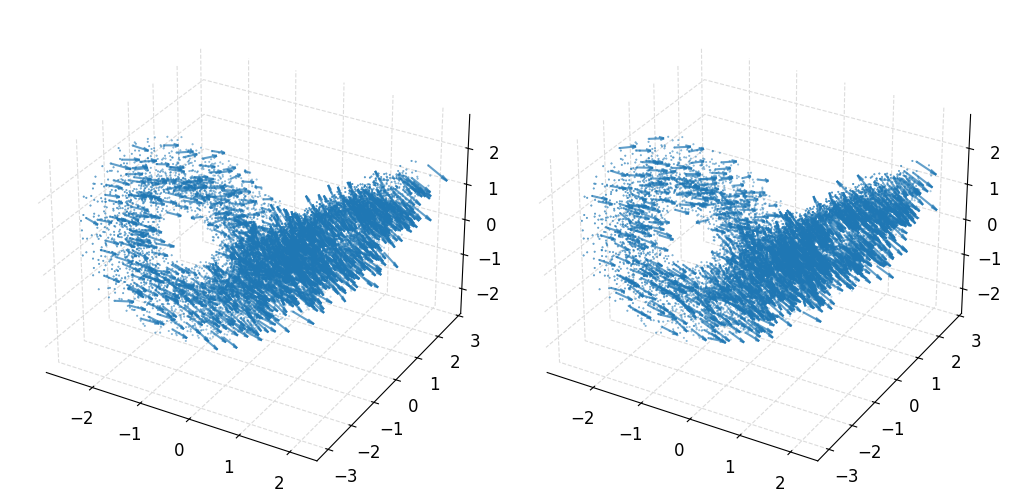

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "3d"})
for i, ax in enumerate(axes):
    ax.scatter(*u[:, i].T, s=0.2)
    ax.quiver(*u[::10, i].T, *normals_batch[::10, i].T, length=0.5, alpha=0.7)

In [46]:
from functools import partial


class NormalODE(AbstractODE):
    ode: AbstractODE

    @property
    def dim(self) -> int:
        return self.ode.dim * (self.ode.dim + 1)

    def rhs(self, t, u: tuple[Float[Array, " dim"], Float[Array, "dim dim"]], args):
        x, Nx = u

        def rhs_ode(x_):
            return self.ode.rhs(t, x_, args)

        dx, vjp_fun = jax.vjp(rhs_ode, x)
        dNx = -vjp_fun(Nx)[0]

        return dx, dNx

    @property
    def default_solver(self):
        return self.ode.default_solver

    @property
    def default_atol(self):
        return self.ode.default_atol

    @property
    def default_rtol(self):
        return self.ode.default_rtol


normal_ode = NormalODE(Lorenz63())


In [47]:
t_ind = 100
u_pred, Nu_pred = normal_ode.solve(
    t_train[t_ind : t_ind + 2], (u[t_ind, 0], normals_batch[t_ind, 0])
)

In [48]:
Nu_pred.shape

(2, 3)

In [49]:
def directional_cosine_squared(x1, x2):
    denom = jnp.sum(x1 * x1) * jnp.sum(x2 * x2)
    return jnp.dot(x1, x2) ** 2 / denom

In [50]:
directional_cosine_squared(Nu_pred[1], normals_batch[t_ind, 1])

Array(0.97713196, dtype=float64)

In [51]:
class NormalLoss(AbstractDynamicsLoss):
    batch_size: int | None = None

    def __call__(
        self,
        model: AbstractDynamicsModel,
        batch: PyTree[Float[Array, "batch ..."]],
        args: Any = None,
        **kwargs: Any,
    ) -> FloatScalar:
        t_data, u_data, Nu_data = batch
        batch_size = u_data.shape[0] if self.batch_size is None else self.batch_size

        @partial(batched_vmap, in_axes=(0, 0, 0), batch_size=batch_size)
        def _loss(t_data_: Float[Array, " time"], u_data_, Nu_data_):
            u_pred, Nu_pred = model.solve(
                t_data_, (u_data_[0], Nu_data_[0]), args, **kwargs
            )
            mse_u = jnp.mean((u_pred - u_data_) ** 2)
            cos_sqr = jax.vmap(directional_cosine_squared)(Nu_data_, Nu_pred)
            return mse_u, 1 - cos_sqr

        mse_, sin_sqr_ = _loss(t_data, u_data, Nu_data)
        mse_total = jnp.mean(mse_)
        sin_sqr_total = jnp.mean(sin_sqr_)
        return mse_total + sin_sqr_total, {
            "mse": mse_total,
            "normal_loss": sin_sqr_total,
        }

In [52]:
batch = (t, u, normals_batch)

In [53]:
loss = NormalLoss()
loss(normal_ode, batch)

(Array(1.67403277, dtype=float64),
 {'mse': Array(1.57454277, dtype=float64),
  'normal_loss': Array(0.09949, dtype=float64)})